# Two moons

We learn the two moons distribution, conditioned on the class label.

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from neural_flow import Flow, train
from neural_flow.bijectors import RollingSplineCoupling, ShiftBounds
import optax

In [2]:
X, C = make_moons(10_000, noise=0.1, random_state=1)
X_train, X_test, C_train, C_test = train_test_split(X, C, random_state=1)

flow = Flow()

variables, best_epoch, train_losses, test_losses = train(
    flow,
    X_train,
    X_test,
    C_train,
    C_test,
    optimizer=optax.nadamw(learning_rate=1e-3),
    epochs=100,
)
test_losses[best_epoch]

Output()

1.8708864450454712

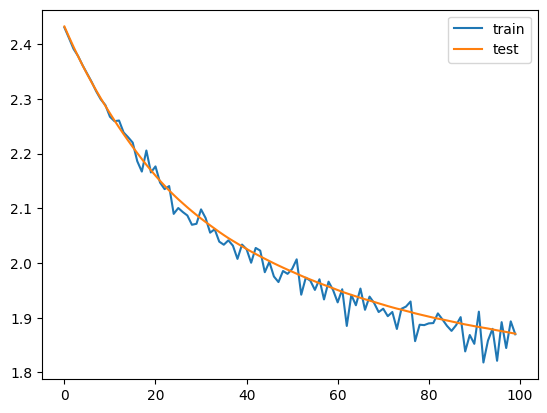

In [3]:
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.legend();

In [4]:
Cm = C_test[:1000]
Xm = flow.sample(variables, Cm)
plt.scatter(*Xm.T, c=Cm, marker="o", alpha=0.3)
plt.scatter(*X_test[:1000].T, c=C_test[:1000], marker="+", alpha=0.3);

TypeError: 'int' object is not callable

Now we test the learning without conditional features. We learn the two-moons distribution without using class labels.

In [ ]:
flow = Flow(
    ShiftBounds(),
    RollingSplineCoupling(make_network=lambda n: FeedForwardNetwork(n, 3, 128)),
)

params, best_epoch, train_losses, test_losses = train(
    flow, X_train, X_test, optimizer=optax.adam(learning_rate=1e-3)
)
test_losses[best_epoch]

Output()

1.0701392889022827

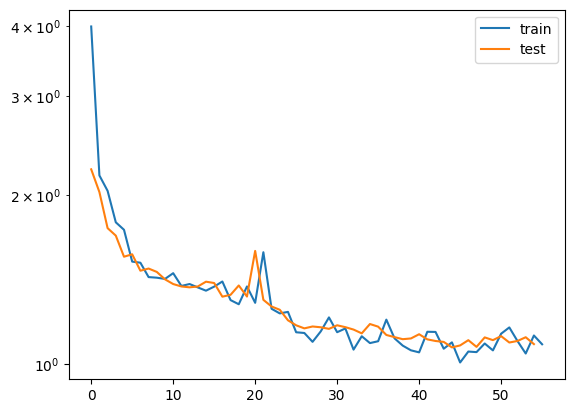

In [ ]:
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.semilogy()
plt.legend();

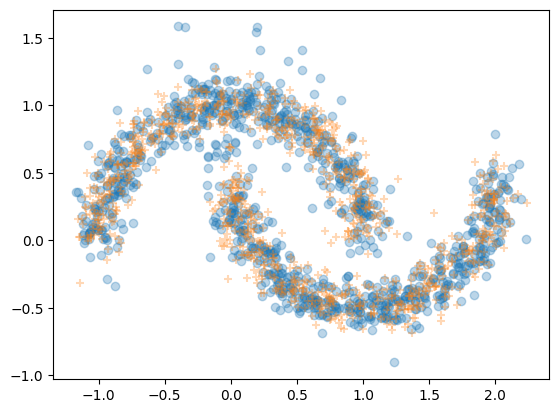

In [ ]:
Xm = flow.sample(params, 1000)
plt.scatter(*Xm.T, marker="o", alpha=0.3)
plt.scatter(*X_test[:1000].T, marker="+", alpha=0.3);